# 1. Install module to generate the .h5 model

In [10]:
!pip install pyyaml h5py

# 2. Import Libraries

In [23]:
import sys
path = "/content/EEGNet"
sys.path.append(path)

# Filesystem
import os
import zipfile

# Filesystem
import os
import zipfile

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# AI-related
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
import itertools

#EEGNET
from EEGModels import DeepConvNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# 3. Functions

Confusion matrix

In [12]:
def plot_confusion_matrix (cm,
                           classes,
                           normalize = False,
                           title = 'Confusion Matrix',
                           cmap=plt.cm.Greens
                          ):
  plt.imshow (cm, interpolation='nearest', cmap=cmap)
  plt.title (title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(cm)

  thresh = cm.max()*0.80
  for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, round(cm[i,j],2),
              horizontalalignment="center",
              color="white" if cm [i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

Normalize input data

In [13]:
def normalize_channels (data, n_channels):
  data_norm = np.zeros_like(data, dtype='float32')
  for ch in range (n_channels):
      min_val = (np.min(data[ch]))
      max_val = (np.max(data[ch]))
      data_norm [ch] = (data[ch] - min_val) / (max_val - min_val)

  return data_norm

# 4. Define the parameters for EEG data

In [14]:
n_channels = 20
n_samples = 128
n_kernels = 1

ch_names = ['Fz', 'F7', 'F3', 'F4', 'F8',
            'T7', 'C3', 'CZ', 'C4', 'T8',
            'P7', 'P3', 'Pz', 'P4', 'P8',
            'O1', 'Oz', 'O2', 'LM', 'RM']

sfreq = 128

# 5. Load test data for the model

In [15]:
# unzip
local_zip = "/content/ERP_Pretest_Data_128Hz.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/ERP_Pretest_Data_128_Hz")
zip_ref.close()

In [6]:
#data path
test_data_path = "/content/ERP_Pretest_Data_128_Hz/Test/"

In [7]:
#load list
testlist = open  ("/content/ERP_Pretest_Data_128_Hz/TestFileList.txt", "r")
data_ = testlist.read()
test_data_all_files = data_.split("\n")

In [8]:
n_trials_test = len(test_data_all_files)

In [16]:
test_set_2D = np.zeros ((n_trials_test,n_channels*n_samples), dtype='float32')

In [17]:
trial = 0
for filename in test_data_all_files:
  data = pd.read_csv(filename, header=None, dtype=np.float32)
  trl = np.reshape (np.array(data), (n_channels*n_samples))
  test_set_2D[trial:] = trl
  trial=trial+1

In [18]:
test_labels_path = '/content/ERP_Pretest_Data_128_Hz/TestLabels.csv'
test_labels = np.array(pd.read_csv(test_labels_path, header=None, dtype='uint8'))
test_labels = np.squeeze(test_labels.T)

In [19]:
oversampler_test = RandomOverSampler(sampling_strategy='minority')
testdata_over, testlabel_over = oversampler_test.fit_resample(test_set_2D, test_labels)
(overTrials_ts,overSamples_ts) = testdata_over.shape

In [20]:
X_test = np.zeros((overTrials_ts,n_channels,n_samples), dtype=np.float32)

In [21]:
for i in range(overTrials_ts):
  trl_rs = np.reshape (testdata_over[i],(n_channels,n_samples))
  # Optional operation to check if this improves the model performance
  trl_rs = normalize_channels(np.array(trl_rs, dtype='float32'), n_channels)
  X_test[i] = trl_rs

# reasign the training labels
y_test = testlabel_over
print(y_test.shape)

(350,)


# 6. Generate Model architecture

In [22]:
# Model Build
classes = 2
dropout_rate = 0.2                  # hp.Float  ('dropoutRate',  min_value=0.2, max_value=0.5, sampling="log")

# Compile
lr = 1e-4

In [24]:
DeepConvNet_Model0 = DeepConvNet(nb_classes = classes,
                       Chans = n_channels,
                       Samples = n_samples,
                       dropoutRate = dropout_rate)

DeepConvNet_Model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 124, 25)       150       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 124, 25)        12525     
                                                                 
 batch_normalization (Batch  (None, 1, 124, 25)        100       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1, 124, 25)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 62, 25)         0         
 D)                                                          

In [25]:
import keras
from keras import optimizers

opt = keras.optimizers.Adam(learning_rate = lr)

DeepConvNet_Model0.compile(loss='binary_crossentropy',
               optimizer=opt,
               metrics = ['accuracy'])

# 7. Generate the model

In [28]:
# load weights from external file

DeepConvNet_Model0.load_weights('/content/Weights/DeepConvNet_Model1.h5')

# 8. Evaluate model

In [29]:
Y_probs       = DeepConvNet_Model0.predict(X_test)
Y_preds       = Y_probs.argmax(axis = -1)
#acc         = np.mean(preds == y_test_model.argmax(axis=-1))
#print("Classification accuracy: %.2f " % (acc))

11/11 [==============================] - 1s 18ms/step


# 9. Confusion Matrix

Confusion matrix, without normalization
[[152  23]
 [142  33]]


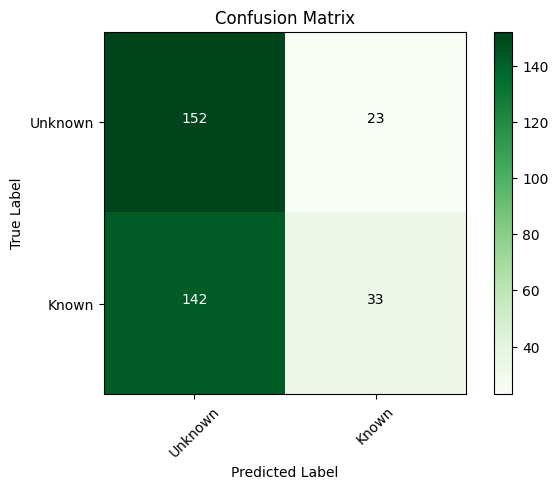

In [30]:
cm = confusion_matrix((y_test), Y_preds)
cm_plot_labels = ['Unknown', 'Known']
plot_confusion_matrix(cm, cm_plot_labels, normalize=False, title='Confusion Matrix')

Normalized confusion matrix
[[0.86857143 0.13142857]
 [0.81142857 0.18857143]]


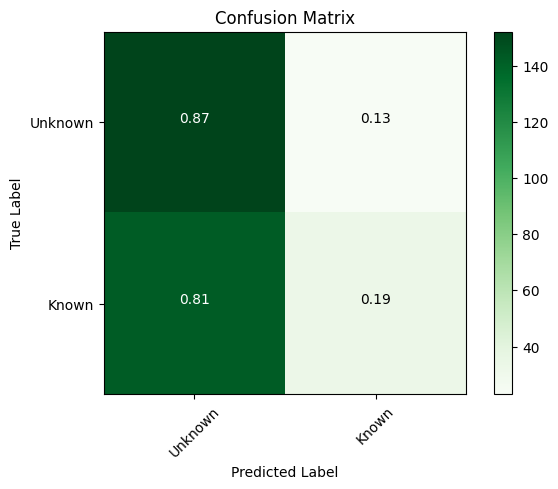

In [31]:
cm = confusion_matrix((y_test), Y_preds)
cm_plot_labels = ['Unknown', 'Known']
plot_confusion_matrix(cm, cm_plot_labels, normalize=True, title='Confusion Matrix')

# 10. Export model data

Model .h5 file

In [32]:
DeepConvNet_Model0.save('/content/Models/DeepConvNet_Model0.keras')
DeepConvNet_Model0.save('/content/Models/DeepConvNet_Model0.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
outputfile = '/content/Models/DeepConvNet_Model0.csv'
df = pd.DataFrame({'Y_Test': y_test, 'Unknown Prob': Y_probs[:,0], 'Known_Prob': Y_probs[:,1], 'Y_preds': Y_preds})
df.to_csv(outputfile,sep=';')

# 11. Load the saved model to check it was correctly saved

In [37]:
from tensorflow.keras.models import load_model
testmodel =load_model('/content/Models/DeepConvNet_Model0.h5')